In [1]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# import xgboost as xgb 
# import lightgbm as lgbm
import catboost as catb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve, f1_score)

In [2]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [3]:
TRAIN_DATASET_PATH = './Jupiter/gb-credit-default/train.csv'
TEST_DATASET_PATH = './Jupiter/gb-credit-default/test.csv'
SAMPLE_SUBMIT_PATH = './Jupiter/gb-credit-default/sample_submission.csv'

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [5]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("TEST\n", round(f1_score(y_valid, y_valid_pred), 3))
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

### Data fields

##### Home Ownership - домовладение
##### Annual Income - годовой доход
##### Years in current job - количество лет на текущем месте работы
##### Tax Liens - налоговые обременения
##### Number of Open Accounts - количество открытых счетов
##### Years of Credit History - количество лет кредитной истории
##### Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
##### Number of Credit Problems - количество проблем с кредитом
##### Months since last delinquent - количество месяцев с последней просрочки платежа
##### Bankruptcies - банкротства
##### Purpose - цель кредита
##### Term - срок кредита
##### Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
##### Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
##### Monthly Debt - ежемесячный долг
##### Credit Score - баллы кредитного рейтинга
##### Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### EDA

In [7]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

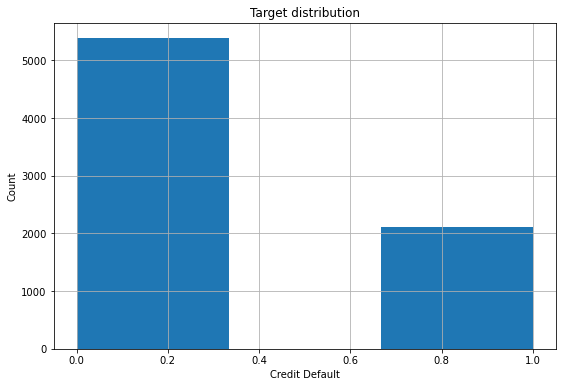

In [8]:
train_df['Credit Default'].hist(figsize = (9, 6), bins = 3)

plt.ylabel('Count')
plt.xlabel('Credit Default')
plt.title('Target distribution')

plt.show()

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [10]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [12]:
test_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


##### Матрица корреляций

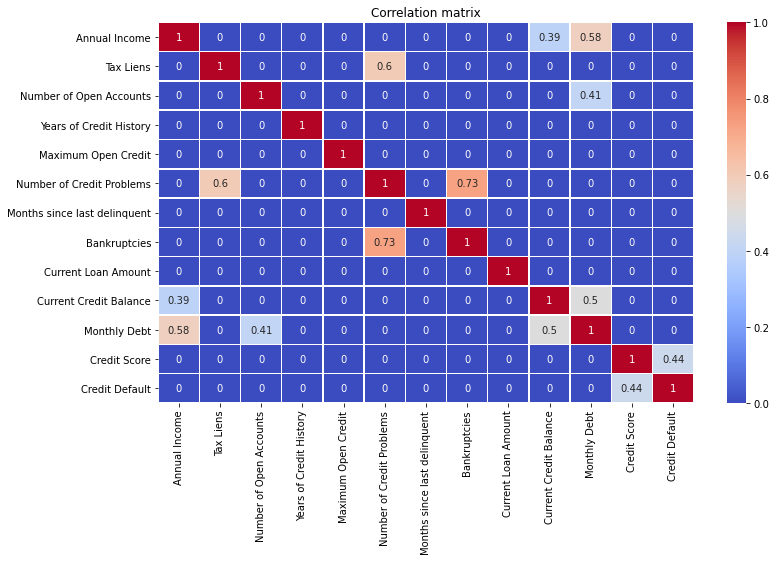

In [13]:
plt.figure(figsize=(12, 7))

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

**Выделение целевой переменной и групп признаков**

In [14]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = train_df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
                     'Monthly Deb', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership ', 'Years in current job ', 'Purpose ', 'Term']

**Корреляция с базовыми признаками**

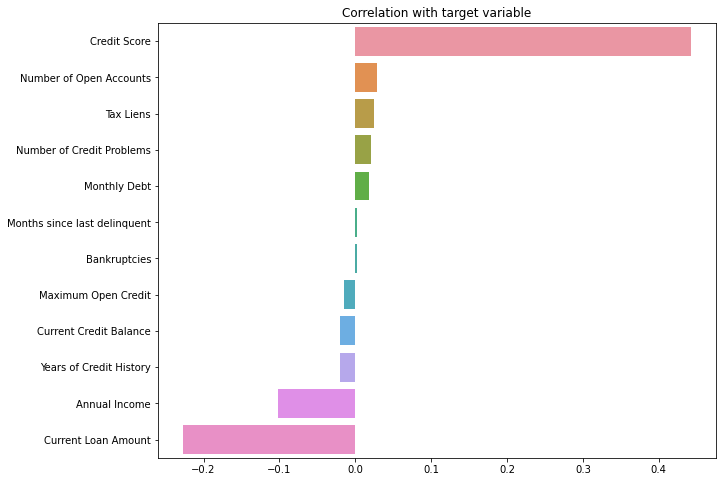

In [15]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

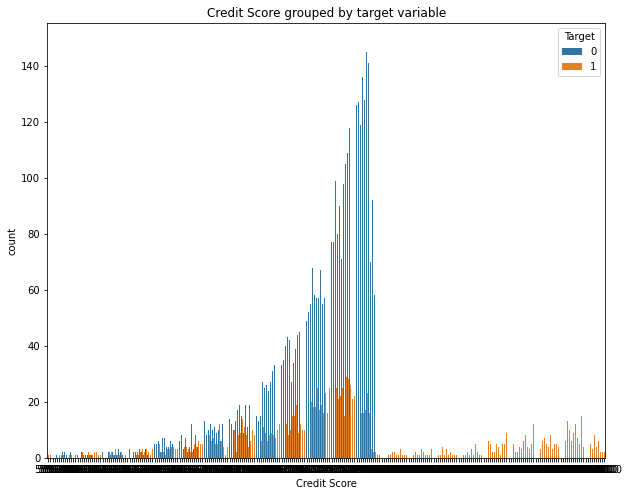

In [16]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Credit Score", hue=TARGET_NAME, data=train_df)
plt.title('Credit Score grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

### Working with train data

In [17]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [18]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [19]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

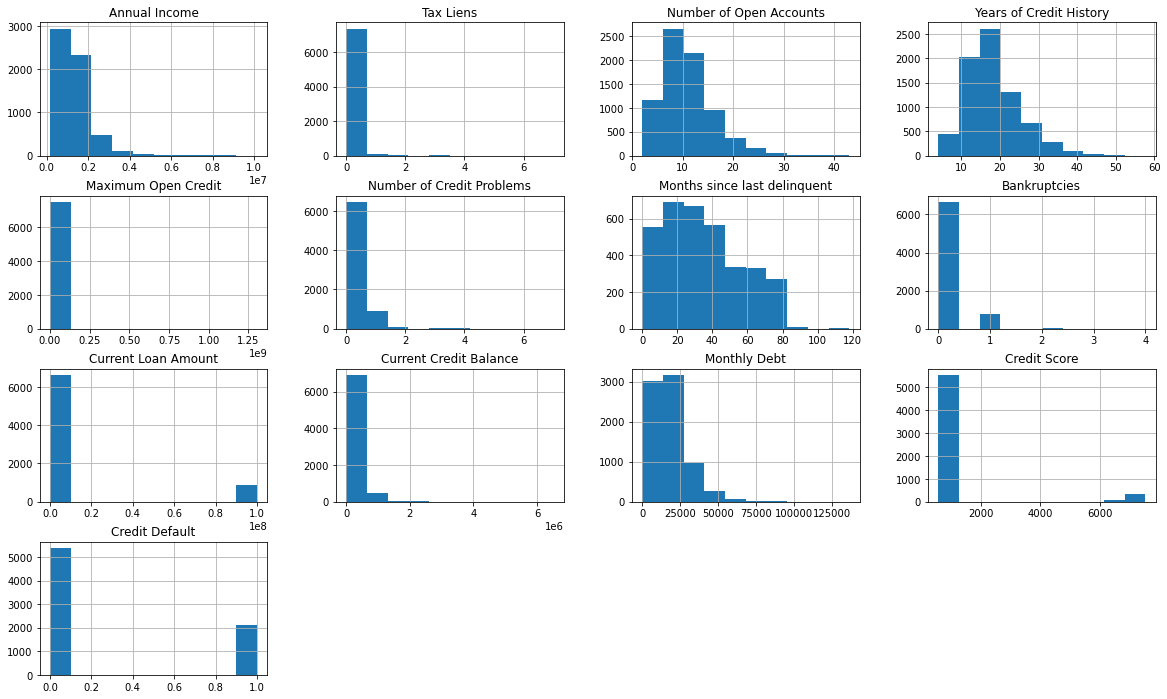

In [20]:
train_df.hist(figsize = (20, 12))
plt.show()

### Working with Annual Income data

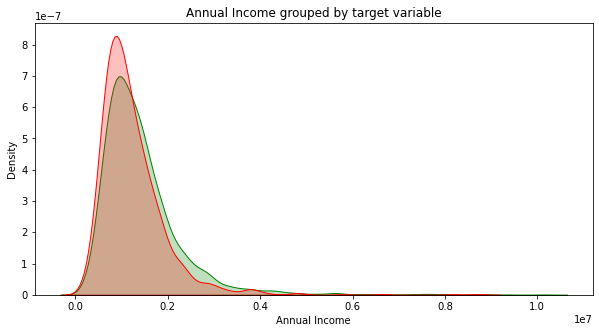

In [21]:
Annual_Income_with_target = train_df[['Annual Income', TARGET_NAME]]
Annual_Income = Annual_Income_with_target['Annual Income']
Annual_Income_target_0 = Annual_Income[Annual_Income_with_target[TARGET_NAME] == 0]
Annual_Income_target_1 = Annual_Income[Annual_Income_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Annual_Income_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(Annual_Income_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

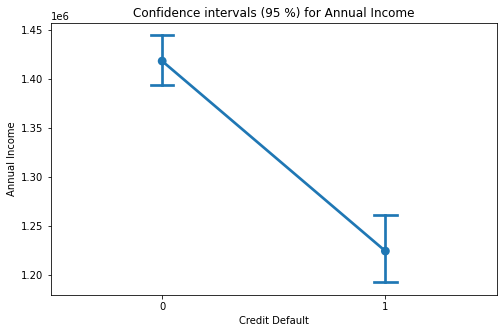

In [22]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=Annual_Income_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

In [23]:
train_df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

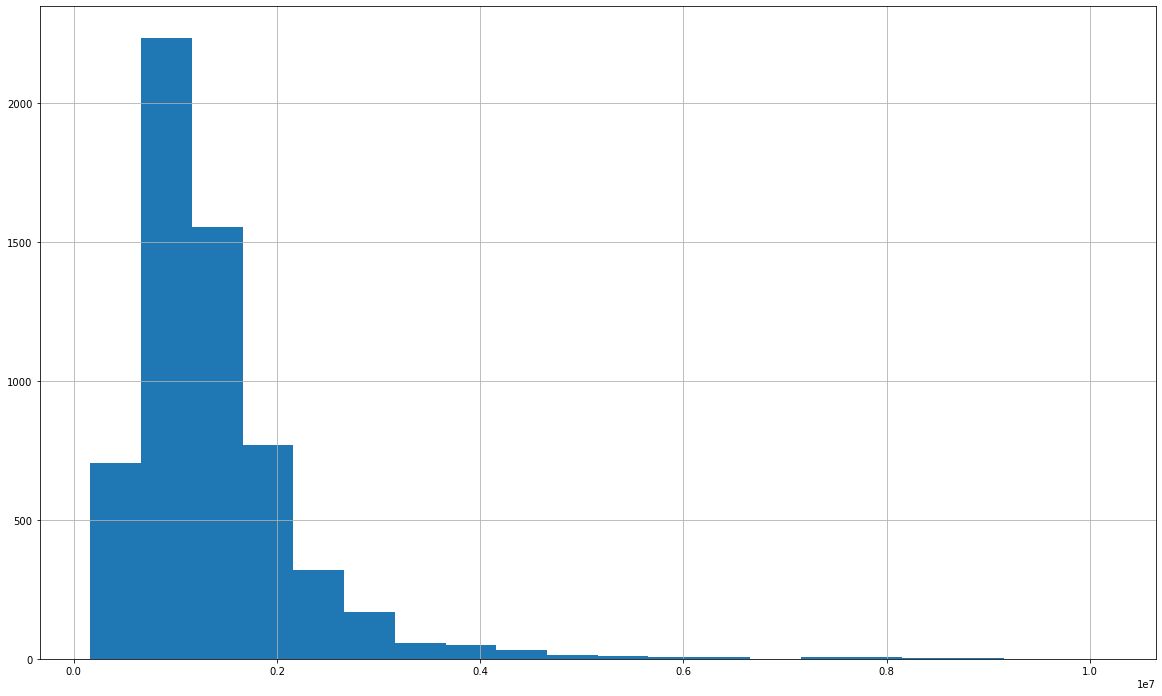

In [24]:
train_df['Annual Income'].hist(figsize = (20, 12), bins = 20)
plt.show()

In [25]:
train_df['Annual Income'].fillna(train_df['Annual Income'].median(), inplace=True)

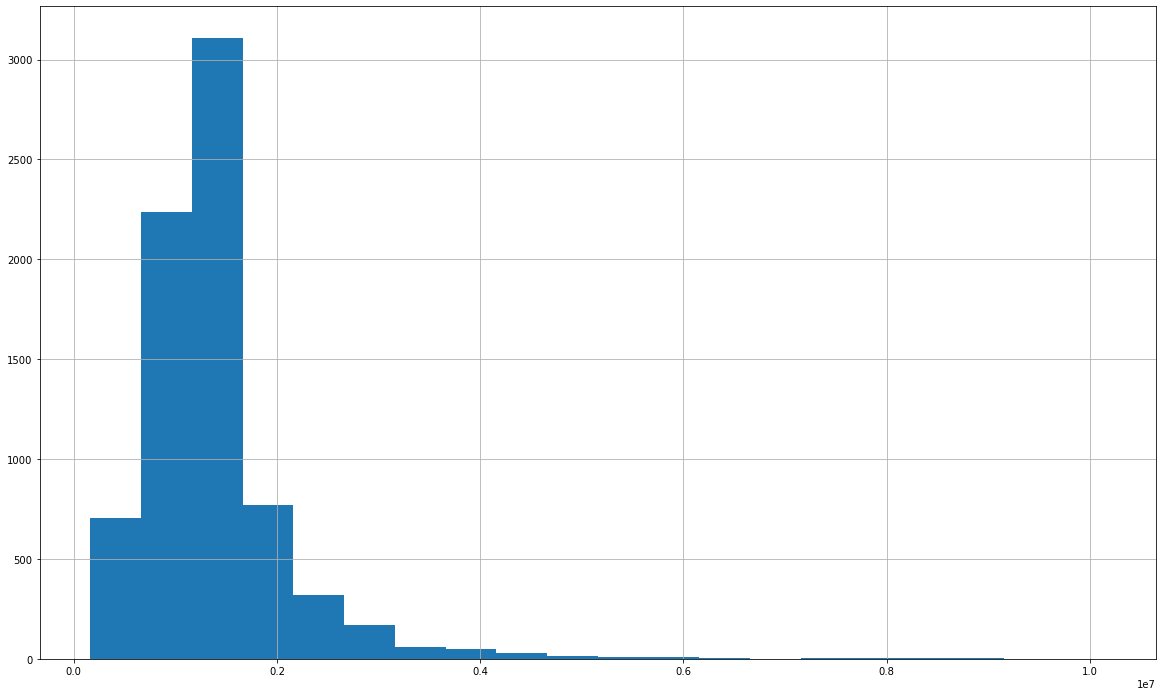

In [26]:
train_df['Annual Income'].hist(figsize = (20, 12), bins = 20)
plt.show()

In [27]:
train_df['Annual Income'].isna().sum()

0

In [28]:
min_annual_income = train_df['Annual Income'].quantile(0.025)
max_annual_income = train_df['Annual Income'].quantile(0.975)
condition = (train_df['Annual Income'] > max_annual_income) | (train_df['Annual Income'] < min_annual_income)

In [29]:
train_df.loc[condition, 'Annual Income'] = train_df['Annual Income'].median()

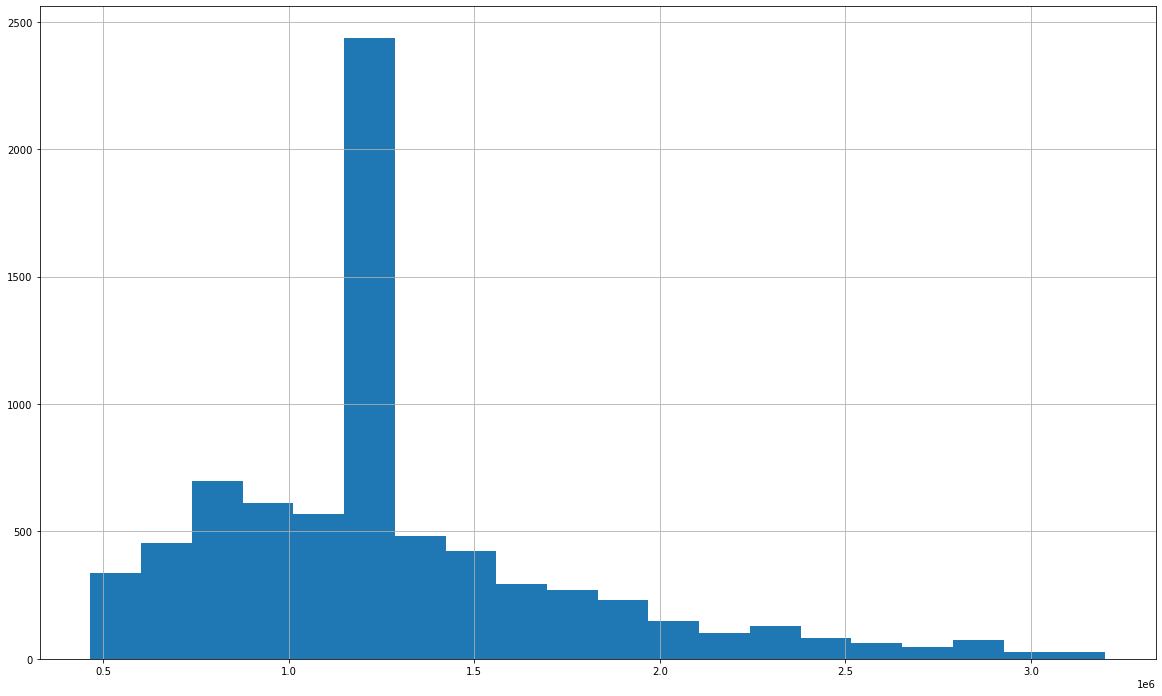

In [30]:
train_df['Annual Income'].hist(figsize = (20, 12), bins = 20)
plt.show()

### Working with Tax Liens data

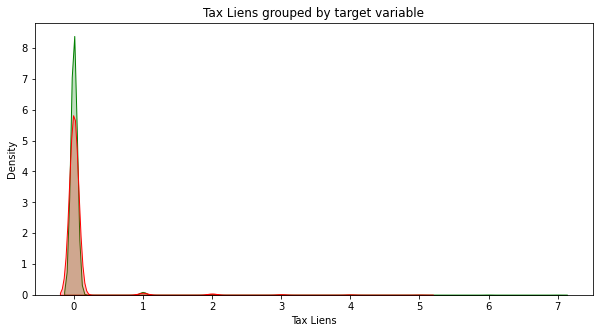

In [31]:
Tax_Liens_with_target = train_df[['Tax Liens', TARGET_NAME]]
Tax_Liens = Tax_Liens_with_target['Tax Liens']
Tax_Liens_target_0 = Tax_Liens[Tax_Liens_with_target[TARGET_NAME] == 0]
Tax_Liens_target_1 = Tax_Liens[Tax_Liens_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Tax_Liens_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(Tax_Liens_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Tax Liens')
plt.title('Tax Liens grouped by target variable')
plt.show()

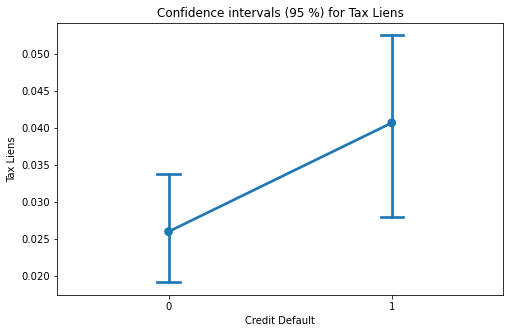

In [32]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Tax Liens', data=Tax_Liens_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Tax Liens')
plt.show()

In [33]:
train_df['Tax Liens']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7495    0.0
7496    0.0
7497    0.0
7498    0.0
7499    0.0
Name: Tax Liens, Length: 7500, dtype: float64

In [34]:
train_df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

### Working with Number of Open Accounts data

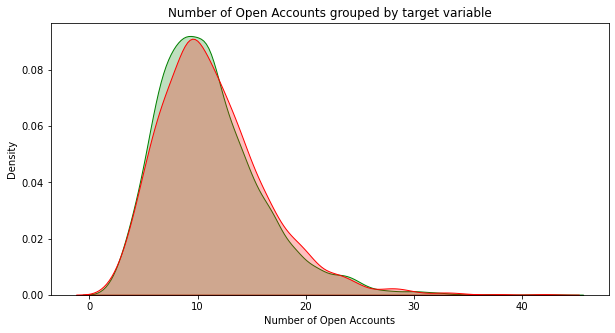

In [35]:
Number_of_Open_Accounts_with_target = train_df[['Number of Open Accounts', TARGET_NAME]]
Number_of_Open_Accounts = Number_of_Open_Accounts_with_target['Number of Open Accounts']
Number_of_Open_Accounts_target_0 = Number_of_Open_Accounts[Number_of_Open_Accounts_with_target[TARGET_NAME] == 0]
Number_of_Open_Accounts_target_1 = Number_of_Open_Accounts[Number_of_Open_Accounts_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Number_of_Open_Accounts_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(Number_of_Open_Accounts_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Number of Open Accounts')
plt.title('Number of Open Accounts grouped by target variable')
plt.show()

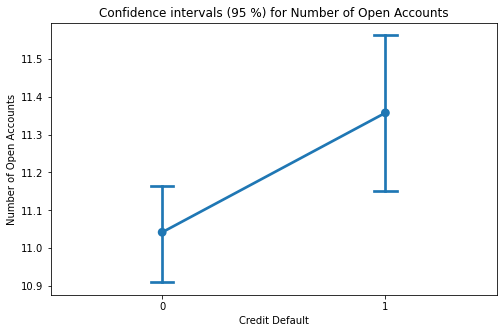

In [36]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Number of Open Accounts', data=Number_of_Open_Accounts_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Number of Open Accounts')
plt.show()

In [37]:
train_df['Number of Open Accounts']

0       11.0
1       15.0
2       11.0
3        8.0
4       13.0
        ... 
7495     3.0
7496    10.0
7497    12.0
7498    21.0
7499     8.0
Name: Number of Open Accounts, Length: 7500, dtype: float64

In [38]:
train_df['Number of Open Accounts'].describe()

count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

### Working with Years of Credit History data

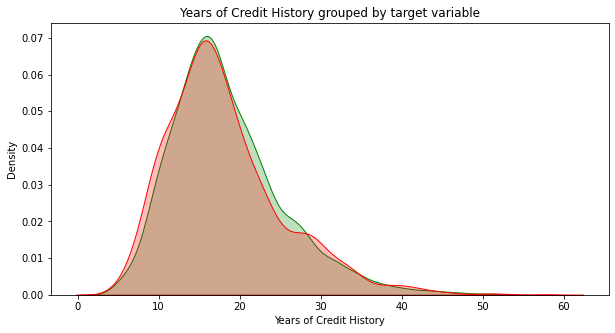

In [39]:
Years_of_Credit_History_with_target = train_df[['Years of Credit History', TARGET_NAME]]
Years_of_Credit_History = Years_of_Credit_History_with_target['Years of Credit History']
Years_of_Credit_History_target_0 = Years_of_Credit_History[Years_of_Credit_History_with_target[TARGET_NAME] == 0]
Years_of_Credit_History_target_1 = Years_of_Credit_History[Years_of_Credit_History_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Years_of_Credit_History_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(Years_of_Credit_History_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Years of Credit History')
plt.title('Years of Credit History grouped by target variable')
plt.show()

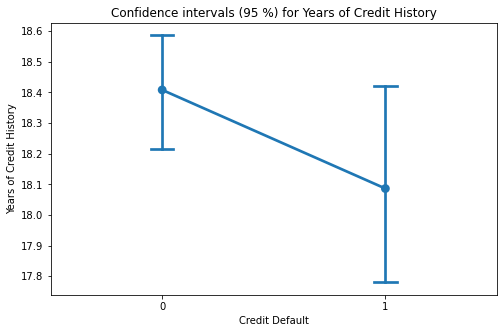

In [40]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Years of Credit History', data=Years_of_Credit_History_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Years of Credit History')
plt.show()

In [41]:
train_df['Years of Credit History']

0       26.3
1       15.3
2       35.0
3       22.5
4       13.6
        ... 
7495     8.5
7496    26.5
7497    32.1
7498    26.5
7499     9.4
Name: Years of Credit History, Length: 7500, dtype: float64

In [42]:
train_df['Years of Credit History'].describe()

count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.800000
max        57.700000
Name: Years of Credit History, dtype: float64

### Working with Maximum Open Credit data

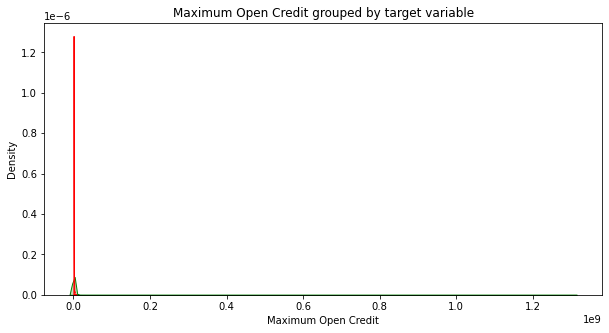

In [43]:
Maximum_Open_Credit_with_target = train_df[['Maximum Open Credit', TARGET_NAME]]
Maximum_Open_Credit = Maximum_Open_Credit_with_target['Maximum Open Credit']
Maximum_Open_Credit_target_0 = Maximum_Open_Credit[Maximum_Open_Credit_with_target[TARGET_NAME] == 0]
Maximum_Open_Credit_target_1 = Maximum_Open_Credit[Maximum_Open_Credit_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Maximum_Open_Credit_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(Maximum_Open_Credit_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Maximum Open Credit')
plt.title('Maximum Open Credit grouped by target variable')
plt.show()

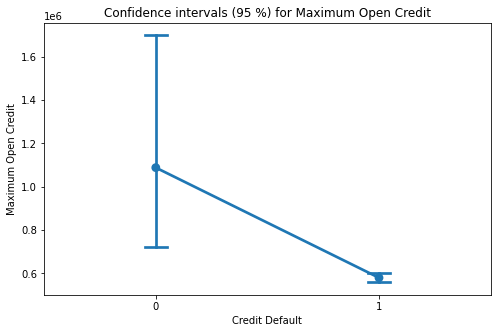

In [44]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Maximum Open Credit', data=Maximum_Open_Credit_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Maximum Open Credit')
plt.show()

In [45]:
train_df['Maximum Open Credit']

0        685960.0
1       1181730.0
2       1182434.0
3        147400.0
4        385836.0
          ...    
7495     107866.0
7496     686312.0
7497    1778920.0
7498    1141250.0
7499     480832.0
Name: Maximum Open Credit, Length: 7500, dtype: float64

In [46]:
train_df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [47]:
limit_for_credit = 99999999.0

In [48]:
(train_df['Maximum Open Credit'] > limit_for_credit).sum()

3

In [49]:
train_df['Maximum Open Credit Outlier'] = 0
train_df.loc[train_df['Maximum Open Credit'] > limit_for_credit, 'Maximum Open Credit Outlier'] = 1
train_df.loc[train_df['Maximum Open Credit'] > limit_for_credit, 'Maximum Open Credit'] = limit_for_credit

### Working with Number of Credit Problems data

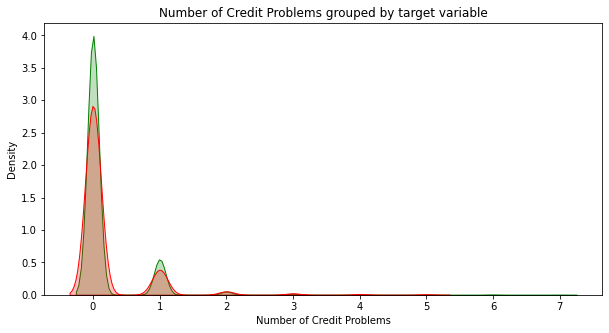

In [50]:
Number_of_Credit_Problems_with_target = train_df[['Number of Credit Problems', TARGET_NAME]]
Number_of_Credit_Problems = Number_of_Credit_Problems_with_target['Number of Credit Problems']
Number_of_Credit_Problems_target_0 = Number_of_Credit_Problems[Number_of_Credit_Problems_with_target[TARGET_NAME] == 0]
Number_of_Credit_Problems_target_1 = Number_of_Credit_Problems[Number_of_Credit_Problems_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Number_of_Credit_Problems_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(Number_of_Credit_Problems_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Number of Credit Problems')
plt.title('Number of Credit Problems grouped by target variable')
plt.show()

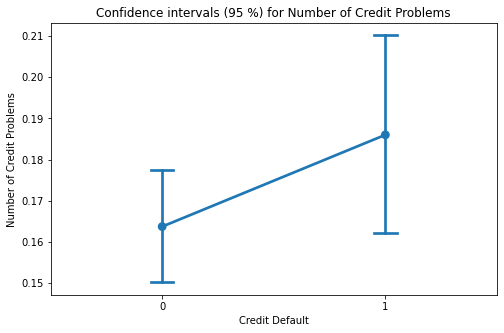

In [51]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Number of Credit Problems', data=Number_of_Credit_Problems_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Number of Credit Problems')
plt.show()

In [52]:
train_df['Number of Credit Problems']

0       1.0
1       0.0
2       0.0
3       1.0
4       1.0
       ... 
7495    0.0
7496    0.0
7497    0.0
7498    0.0
7499    0.0
Name: Number of Credit Problems, Length: 7500, dtype: float64

In [53]:
train_df['Number of Credit Problems'].describe()

count    7500.000000
mean        0.170000
std         0.498598
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Number of Credit Problems, dtype: float64

### Working with Months since last delinquent data

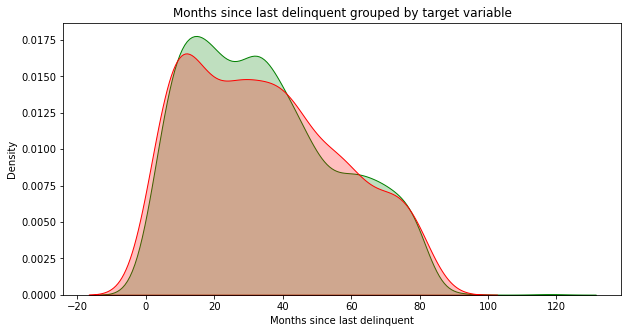

In [54]:
Months_since_last_delinquent_with_target = train_df[['Months since last delinquent', TARGET_NAME]]
Months_since_last_delinquent = Months_since_last_delinquent_with_target['Months since last delinquent']
Months_since_last_delinquent_target_0 = Months_since_last_delinquent[Months_since_last_delinquent_with_target[TARGET_NAME] == 0]
Months_since_last_delinquent_target_1 = Months_since_last_delinquent[Months_since_last_delinquent_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Months_since_last_delinquent_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(Months_since_last_delinquent_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Months since last delinquent')
plt.title('Months since last delinquent grouped by target variable')
plt.show()

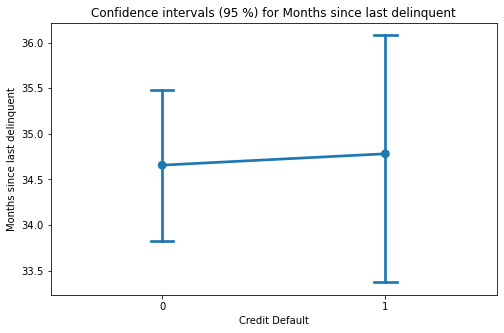

In [55]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Months since last delinquent', data=Months_since_last_delinquent_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Months since last delinquent')
plt.show()

In [56]:
train_df['Months since last delinquent']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
7495     NaN
7496    43.0
7497     NaN
7498     NaN
7499     NaN
Name: Months since last delinquent, Length: 7500, dtype: float64

In [57]:
train_df['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

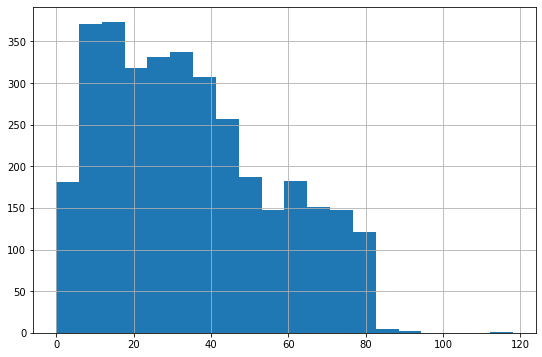

In [58]:
train_df['Months since last delinquent'].hist(figsize = (9, 6), bins = 20)
plt.show()

In [59]:
train_df['Months since last delinquent'].sort_values()

5705    0.0
4995    0.0
4938    0.0
3063    0.0
257     0.0
       ... 
7494    NaN
7495    NaN
7497    NaN
7498    NaN
7499    NaN
Name: Months since last delinquent, Length: 7500, dtype: float64

In [60]:
train_df['Months since last delinquent'].isna().sum()

4081

In [61]:
train_df['Months since last delinquent'].shape[0]

7500

### Working with Bankruptcies data

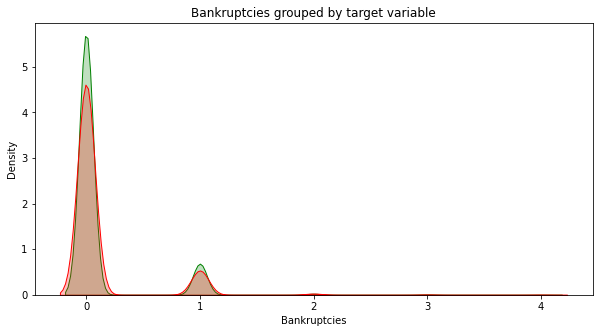

In [62]:
Bankruptcies_with_target = train_df[['Bankruptcies', TARGET_NAME]]
Bankruptcies_b = Bankruptcies_with_target['Bankruptcies']
Bankruptcies_target_0 = Bankruptcies_b[Bankruptcies_with_target[TARGET_NAME] == 0]
Bankruptcies_target_1 = Bankruptcies_b[Bankruptcies_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Bankruptcies_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(Bankruptcies_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Bankruptcies')
plt.title('Bankruptcies grouped by target variable')
plt.show()

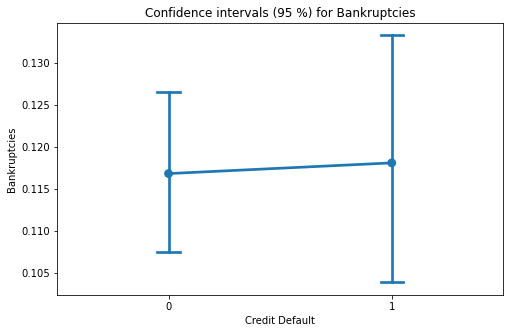

In [63]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Bankruptcies', data=Bankruptcies_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Bankruptcies')
plt.show()

In [64]:
train_df['Bankruptcies']

0       1.0
1       0.0
2       0.0
3       1.0
4       0.0
       ... 
7495    0.0
7496    0.0
7497    0.0
7498    0.0
7499    0.0
Name: Bankruptcies, Length: 7500, dtype: float64

In [65]:
train_df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

### Working with Current Loan Amount data

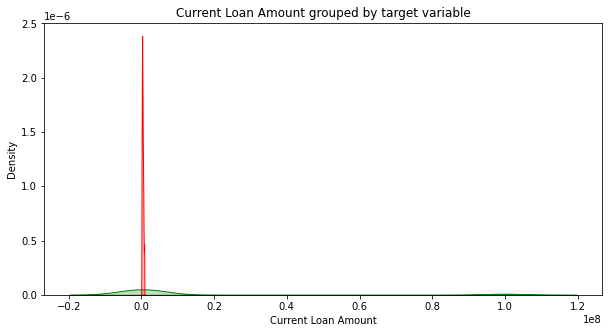

In [66]:
Current_Loan_Amount_with_target = train_df[['Current Loan Amount', TARGET_NAME]]
Current_Loan_Amount = Current_Loan_Amount_with_target['Current Loan Amount']
Current_Loan_Amount_target_0 = Current_Loan_Amount[Current_Loan_Amount_with_target[TARGET_NAME] == 0]
Current_Loan_Amount_target_1 = Current_Loan_Amount[Current_Loan_Amount_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Current_Loan_Amount_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(Current_Loan_Amount_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

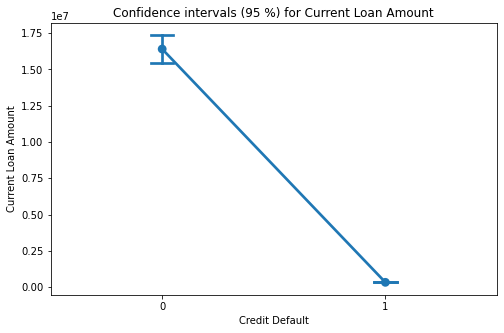

In [67]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=Current_Loan_Amount_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

In [68]:
train_df['Current Loan Amount']

0       99999999.0
1         264968.0
2       99999999.0
3         121396.0
4         125840.0
           ...    
7495      129360.0
7496      444048.0
7497    99999999.0
7498      615274.0
7499       26928.0
Name: Current Loan Amount, Length: 7500, dtype: float64

In [69]:
train_df['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
216106.0        5
265826.0        5
             ... 
104324.0        1
201080.0        1
427812.0        1
665544.0        1
191136.0        1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [70]:
train_df['Current Loan Amount Outlier'] = 0
train_df.loc[train_df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount Outlier'] = 1
train_df.loc[train_df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = train_df['Current Loan Amount'].median()
train_df['Current Loan Amount'].value_counts()

309573.0    870
218064.0      6
89298.0       6
270226.0      5
216106.0      5
           ... 
104324.0      1
201080.0      1
427812.0      1
665544.0      1
191136.0      1
Name: Current Loan Amount, Length: 5386, dtype: int64

### Working with Current Credit Balance data

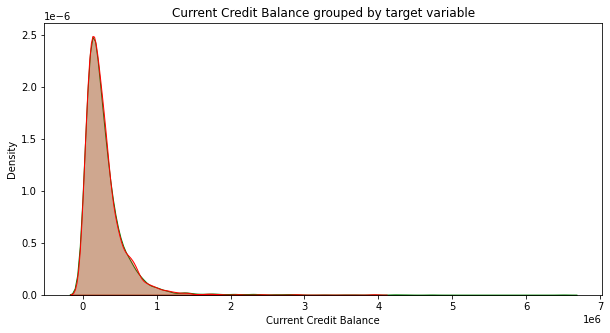

In [71]:
Current_Credit_Balance_with_target = train_df[['Current Credit Balance', TARGET_NAME]]
Current_Credit_Balance = Current_Credit_Balance_with_target['Current Credit Balance']
Current_Credit_Balance_target_0 = Current_Credit_Balance[Current_Credit_Balance_with_target[TARGET_NAME] == 0]
Current_Credit_Balance_target_1 = Current_Credit_Balance[Current_Credit_Balance_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Current_Credit_Balance_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(Current_Credit_Balance_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Current Credit Balance')
plt.title('Current Credit Balance grouped by target variable')
plt.show()

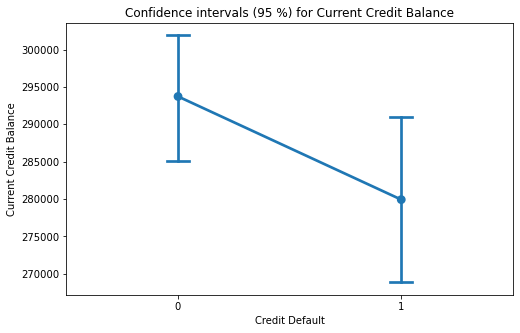

In [72]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Credit Balance', data=Current_Credit_Balance_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Credit Balance')
plt.show()

### Working with Monthly Debt data

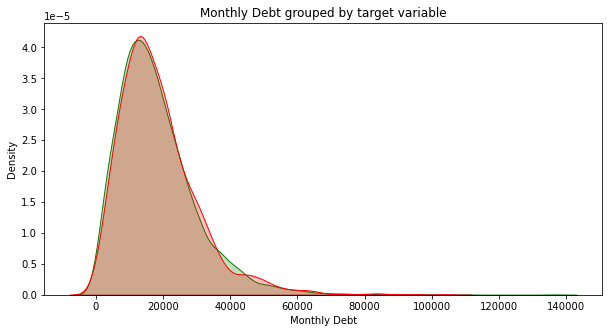

In [73]:
Monthly_Debt_with_target = train_df[['Monthly Debt', TARGET_NAME]]
Monthly_Debt = Monthly_Debt_with_target['Monthly Debt']
Monthly_Debt_target_0 = Monthly_Debt[Monthly_Debt_with_target[TARGET_NAME] == 0]
Monthly_Debt_target_1 = Monthly_Debt[Monthly_Debt_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Monthly_Debt_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(Monthly_Debt_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Monthly Debt')
plt.title('Monthly Debt grouped by target variable')
plt.show()

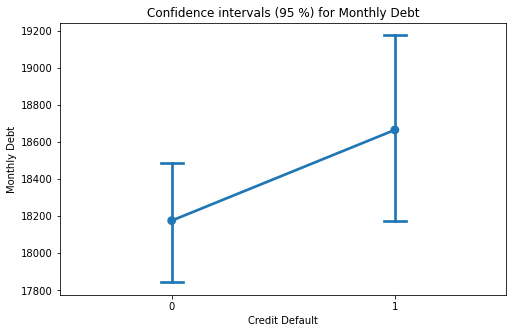

In [74]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Monthly Debt', data=Monthly_Debt_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Monthly Debt')
plt.show()

### Working with Credit Score data

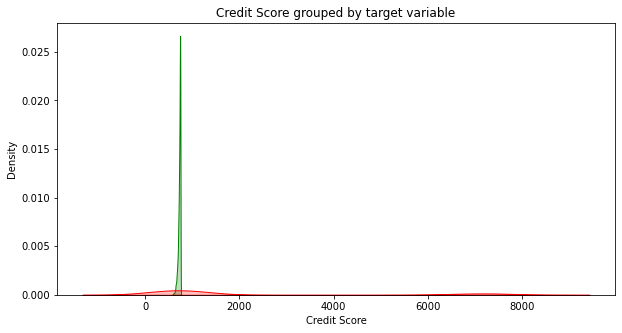

In [75]:
Credit_Score_with_target = train_df[['Credit Score', TARGET_NAME]]
Credit_Score = Credit_Score_with_target['Credit Score']
Credit_Score_target_0 = Credit_Score[Credit_Score_with_target[TARGET_NAME] == 0]
Credit_Score_target_1 = Credit_Score[Credit_Score_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Credit_Score_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(Credit_Score_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

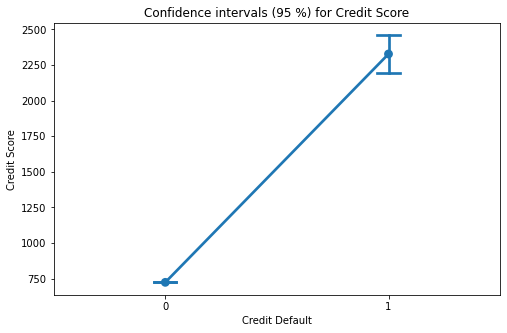

In [76]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=Credit_Score_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

In [77]:
train_df['Credit Score']

0        749.0
1        737.0
2        742.0
3        694.0
4        719.0
         ...  
7495     697.0
7496    7410.0
7497     748.0
7498       NaN
7499       NaN
Name: Credit Score, Length: 7500, dtype: float64

In [78]:
train_df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

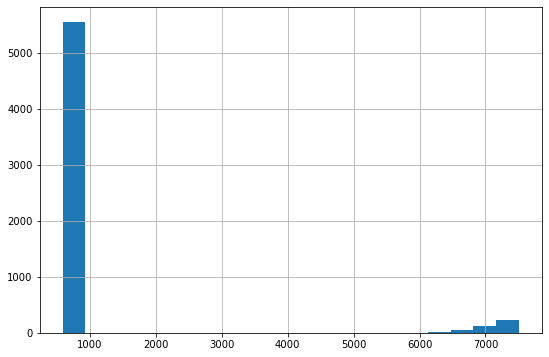

In [79]:
train_df['Credit Score'].hist(figsize = (9, 6), bins = 20)
plt.show()

In [80]:
(train_df['Credit Score'] > 1000).sum()

400

In [81]:
train_df['Credit Score Outlier'] = 0
train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score Outlier'] = 1
train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score'] = train_df.loc[train_df['Credit Score'] > 1000, 'Credit Score'] / 10
(train_df['Credit Score'] > 1000).sum()

0

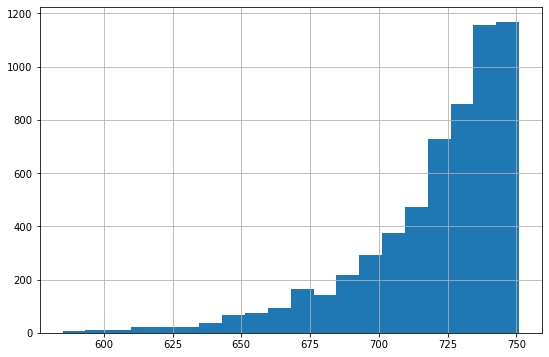

In [82]:
train_df['Credit Score'].hist(figsize = (9, 6), bins = 20)
plt.show()

### Working with NaN

In [83]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                      0
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
Maximum Open Credit Outlier        0
Current Loan Amount Outlier        0
Credit Score Outlier               0
dtype: int64

##### Credit Score                    

<AxesSubplot:>

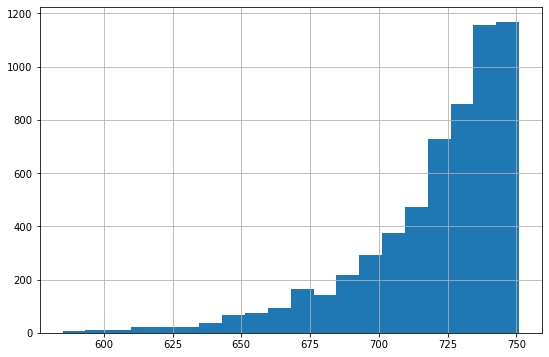

In [84]:
train_df['Credit Score'].hist(figsize = (9, 6), bins = 20)

In [85]:
train_df['Credit Score'].isna().sum()

1557

In [86]:
train_df['Credit Score'].describe()

count    5943.000000
mean      720.086993
std        27.957233
min       585.000000
25%       708.000000
50%       729.000000
75%       740.000000
max       751.000000
Name: Credit Score, dtype: float64

In [87]:
train_df['Credit Score NaN'] = 0

In [88]:
train_df.loc[train_df['Credit Score'].isna(), 'Credit Score NaN'] = 1

In [89]:
train_df.loc[train_df['Credit Score'].isna(), 'Credit Score'] = train_df['Credit Score'].median()

In [90]:
train_df['Credit Score'].isna().sum()

0

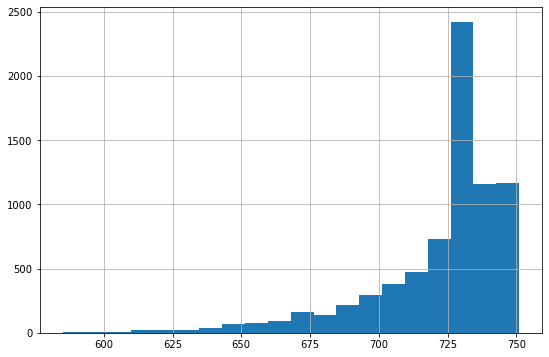

In [91]:
train_df['Credit Score'].hist(figsize = (9, 6), bins = 20)
plt.show()

##### Bankruptcies

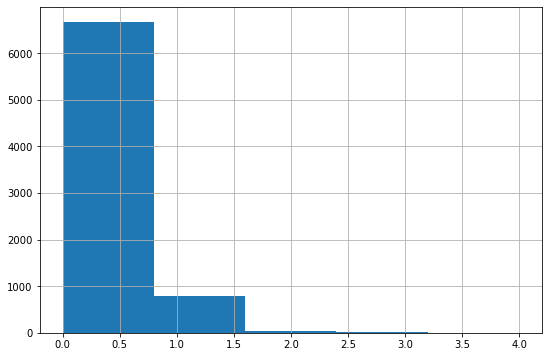

In [92]:
train_df['Bankruptcies'].hist(figsize = (9, 6), bins = 5)
plt.show()

In [93]:
train_df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [94]:
train_df['Bankruptcies'].isna().sum()

14

In [95]:
train_df['Bankruptcies NaN'] = 0

In [96]:
train_df.loc[train_df['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1

In [97]:
train_df.loc[train_df['Bankruptcies'].isna(), 'Bankruptcies'] = train_df['Bankruptcies'].median()

In [98]:
train_df['Bankruptcies'].isna().sum()

0

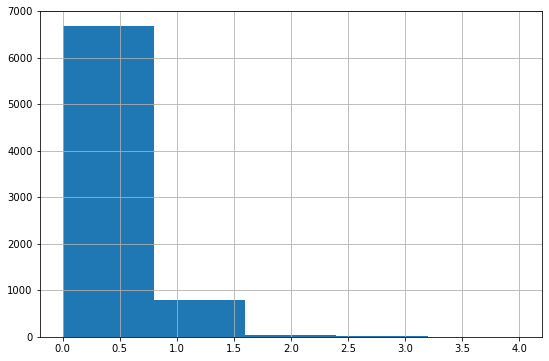

In [99]:
train_df['Bankruptcies'].hist(figsize = (9, 6), bins = 5)
plt.show()

##### Years in current job

In [100]:
train_df['Years in current job'].describe()

count          7129
unique           11
top       10+ years
freq           2332
Name: Years in current job, dtype: object

In [101]:
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [102]:
mode = train_df['Years in current job'].mode()
mode

0    10+ years
dtype: object

In [103]:
train_df['Years in current job NaN'] = 0
train_df.loc[train_df['Years in current job'].isna(), 'Years in current job NaN'] = 1
train_df.loc[train_df['Years in current job'].isna(), 'Years in current job'] = train_df['Years in current job'].mode()

##### Months since last delinquent

In [104]:
train_df['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

In [105]:
train_df['Months since last delinquent'].isna().sum()

4081

In [106]:
#train_df.drop('Months since last delinquent', axis=1, inplace=True)

### Creating new features

In [107]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2333
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [108]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Home Ownership'])], axis=1)

In [109]:
train_df['Years in current job'] = train_df['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':0, 
                                                                       '2 years':1, 
                                                                       '3 years':2, 
                                                                       '4 years':3, 
                                                                       '5 years':4, 
                                                                       '6 years':5, 
                                                                       '7 years':6,
                                                                       '8 years':7,
                                                                       '9 years':8,
                                                                       '10+ years':9})

In [110]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Purpose'])], axis=1)

In [111]:
train_df['Long Term'] = train_df['Term'].map({'Long Term': 1, 'Short Term': 0})

In [112]:
def credit_score_to_cathegory(X):
    bins = [300, 579, 669, 739, 799, 850]
    X['Credit Score Cathegory'] = pd.cut(X['Credit Score'], bins=bins, labels=False)
    
    X['Credit Score Cathegory'].fillna(-1, inplace=True)
    return X

In [113]:
train_df = credit_score_to_cathegory(train_df)

### DataPreprocessing

In [114]:
class DataPreprocessing:
    
    def __init__(self):
        self.medians=None
        self.modes = None
        self.max_score = 850
        self.max_credit = 99999999.0
        
    def fit(self, X):
        X = X.copy()
        self.medians = X.median()
        self.modes = X.mode().loc[0]
                
    def transform(self, X):
        X['Credit Score Outlier'] = 0
        X['Credit Score NaN'] = 0
        X.loc[X['Credit Score'] > self.max_score, 'Credit Score Outlier'] = 1
        X.loc[X['Credit Score'].isna(), 'Credit Score NaN'] = 1

        X.loc[X['Credit Score'] > self.max_score, 'Credit Score'] = \
                                X.loc[train_df['Credit Score'] > self.max_score, 'Credit Score'] / 10
        X['Credit Score'].fillna(self.medians['Credit Score'], inplace = True)
        
        X['Current Loan Amount Outlier'] = 0
        X.loc[X['Current Loan Amount'] == self.max_credit, 'Current Loan Amount Outlier'] = 1
        X.loc[X['Current Loan Amount'] == self.max_credit, 'Current Loan Amount'] = self.medians['Current Loan Amount']
        
        X['Maximum Open Credit Outlier'] = 0
        X.loc[X['Maximum Open Credit'] > limit_for_credit, 'Maximum Open Credit Outlier'] = 1
        X.loc[X['Maximum Open Credit'] > limit_for_credit, 'Maximum Open Credit'] = limit_for_credit
               
        X['Annual Income NaN'] = 0
        X.loc[X['Annual Income'].isna(), 'Annual Income NaN'] = 1
        X['Annual Income'].fillna(self.medians['Annual Income'], inplace = True)
        
        X['Years in current job NaN'] = 0
        X.loc[X['Years in current job'].isna(), 'Years in current job NaN'] = 1
        X['Years in current job'].fillna(self.modes['Years in current job'], inplace = True)
        
        X.drop('Months since last delinquent', axis=1, inplace=True)
        
        X['Bankruptcies NaN'] = 0
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
        X['Bankruptcies'].fillna(self.medians['Bankruptcies'], inplace = True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [115]:
class FeatureGenetator():
    
      
    def fit(self, X, y=None):
        X = X.copy()
                
    def transform(self, X):
        
        X['Long Term'] = X['Term'].map({'Long Term': 1, 'Short Term': 0})
                
        X['Years in current job'] = X['Years in current job'].map({'< 1 year':0, 
                                                                       '1 year':0, 
                                                                       '2 years':1, 
                                                                       '3 years':2, 
                                                                       '4 years':3, 
                                                                       '5 years':4, 
                                                                       '6 years':5, 
                                                                       '7 years':6,
                                                                       '8 years':7,
                                                                       '9 years':8,
                                                                       '10+ years':9})
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'])], axis=1)
        
        X = self.credit_score_to_cathegory(X)
        
        return X
    
    def credit_score_to_cathegory(self, X):
        bins = [300, 579, 669, 739, 799, 850]
        X['Credit Score Cathegory'] = pd.cut(X['Credit Score'], bins=bins, labels=False)

        X['Credit Score Cathegory'].fillna(-1, inplace=True)
        return X

In [116]:
feature_names = ['Annual Income', 
                 'Tax Liens', 
                 'Number of Open Accounts', 
                 'Years of Credit History', 
                 'Maximum Open Credit', 
                 'Number of Credit Problems', 
#                  'Months since last delinquent', 
                 'Bankruptcies',
                 'Current Loan Amount', 
                 'Current Credit Balance', 
                 'Monthly Debt', 
                 'Credit Score', 
                 'Years in current job', 
#                  'Purpose'
                ]

new_feature_names = [
#                          'Home Ownership',
#                          'Term',
#                          'Credit Score Outlier',
#                          'Current Loan Amount Outlier',
#                          'Maximum Open Credit Outlier',
#                          'Annual Income NaN',
#                          'Years in current job NaN',
#                          'Bankruptcies NaN',
#                          'Credit Score NaN',
                         'Long Term',
                        # 'Have Mortgage',
                        # 'Home Mortgage',
                        # 'Own Home',
                        # 'Rent',
                        # 'Credit Score Cathegory'
                    ]

target_name = 'Credit Default'

### Catboost

In [117]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [118]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [119]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)  

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
df_test = preprocessor.transform(test_df)

In [120]:
X_train.shape, X_valid.shape, df_test.shape

((5025, 43), (2475, 43), (2500, 22))

In [121]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)  

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
df_test = features_gen.transform(test_df)

In [122]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [123]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5537482319660536

In [124]:
model_catb = catb.CatBoostClassifier(
                                     silent=True, 
                                     random_state=42,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall'],
                                     iterations=50,
                                     max_depth=5,
                                     min_data_in_leaf=5
                                    )

model_catb.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [125]:
evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN
 0.503
TEST
 0.5
TRAIN

              precision    recall  f1-score   support

           0       0.86      0.44      0.58      3611
           1       0.36      0.82      0.50      1414

    accuracy                           0.54      5025
   macro avg       0.61      0.63      0.54      5025
weighted avg       0.72      0.54      0.56      5025

VALID

              precision    recall  f1-score   support

           0       0.86      0.43      0.57      1776
           1       0.36      0.82      0.50       699

    accuracy                           0.54      2475
   macro avg       0.61      0.62      0.54      2475
weighted avg       0.72      0.54      0.55      2475

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               765  1011
1               129   570


In [126]:
submit = pd.read_csv(SAMPLE_SUBMIT_PATH)
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [127]:
predictions = model_catb.predict(test_df)
submit['Credit Default'] = predictions

In [128]:
submit.to_csv('course_2.2.csv', index=False)